# Imports and Definition of Variables

In [1]:
import tensorflow as tf
from tensorflow import keras
from iterativefaster import *
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns

# Run Pipeline with all parameters of the functions as arguments:
PATH = "/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/"
# Store important variables
BATCHSIZE = 64 
N_EPOCHS = 70
N_CLASSES = 4
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Preprocess the images
BLUR = "none" 
KERNEL = 3 # Changes how the blur is applied, odd numbers only
METHOD = 'clahe' # Apply CLAHE or histogram, or even none (just write something else)
RESIZE = True
IMGSIZE = (88, 104) # Original size [176, 208]
STOREINDF = True # Preferably True to store X in a dataframe
DF = None
IMAGECOLUMNNAME = "image"

# Balance the dataset
TARGETCOLUMN = 'label'
DESIREDSIZE = 2600 # Number of observations to reach for oversample or undersample
VERBOSE = False
OVERSAMP = True
DIVIDE = True # Undersample
ISARRAY = False # Not needed to change unless major change in X and Y format.

# Preprocess the data
SCALER = 'standard'
ENCODER = 'onehot' # Onehot or label, have to change parts of the code for label
XCOL = 'processedImage'
BALANCE = False # Balance class or not
TEST_SIZE = 0.2

# Model parameters
METRICS = ['accuracy']
def exponentialDecay(lr0, s):
    def exponentialDecayFn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponentialDecayFn


SEED = 1318
def set_seed(seed=48):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    RANDOM_STATE = 42
set_seed(SEED)

2024-05-12 12:03:53.868853: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-12 12:03:53.868969: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-12 12:03:54.000899: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Load and Process the Dataset

In [2]:

DO_LOAD = True
DO_PREPROCESS = True
DO_BALANCE = False
DO_PREPROCESSDATA = False
DO_RGB = False

# Load the data
if DO_LOAD:
    # Loads the data
    print("Loading data...")
    TRAIN = loadData(PATH+ 'train')
    TEST = loadData(PATH+ 'test')
    print("Data imported.")

if DO_PREPROCESS:
    # Preprocess the images
    print("Processing images...")
    processImageData(TRAIN[IMAGECOLUMNNAME],blur = BLUR, method=METHOD, resize=True, imgSize=IMGSIZE, df=TRAIN, rescale = False)
    processImageData(TEST[IMAGECOLUMNNAME], blur = BLUR, method=METHOD, resize=True, imgSize=IMGSIZE, df=TEST, rescale = False)
    print("Images processed.")

if DO_PREPROCESSDATA: # use only if a numpy array is preferable
        # Preprocess the data, applying scalers and splitting
        print("Preprocessing the dataset...")
        X_TRAIN, X_VAL, X_TEST, Y_TRAIN, Y_VAL, Y_TEST, SCALER, ENCODER = preprocessData(TRAIN, TEST, scaler=SCALER, encoder=ENCODER, xCol =XCOL, yCol=TARGETCOLUMN, test_size = TEST_SIZE, balance = DO_BALANCE, oversamp = OVERSAMP, undersamp = DIVIDE, samps = DESIREDSIZE)
        print("Dataset preprocessed.")
if DO_RGB: # use only if a numpy array is preferable
    # Turn the image into 3D for the pre-trained models
    TRAIN_RGB = np.repeat(X_TRAIN[..., np.newaxis], 3, -1)
    VAL_RGB = np.repeat(X_VAL[..., np.newaxis], 3, -1)
    TEST_RGB = np.repeat(X_TEST[..., np.newaxis], 3, -1)


Loading data...
Found 5121 images belonging to 4 classes
Found 1279 images belonging to 4 classes
Data imported.
Processing images...
Images processed.


# Visualise the Distribution of the Dataset

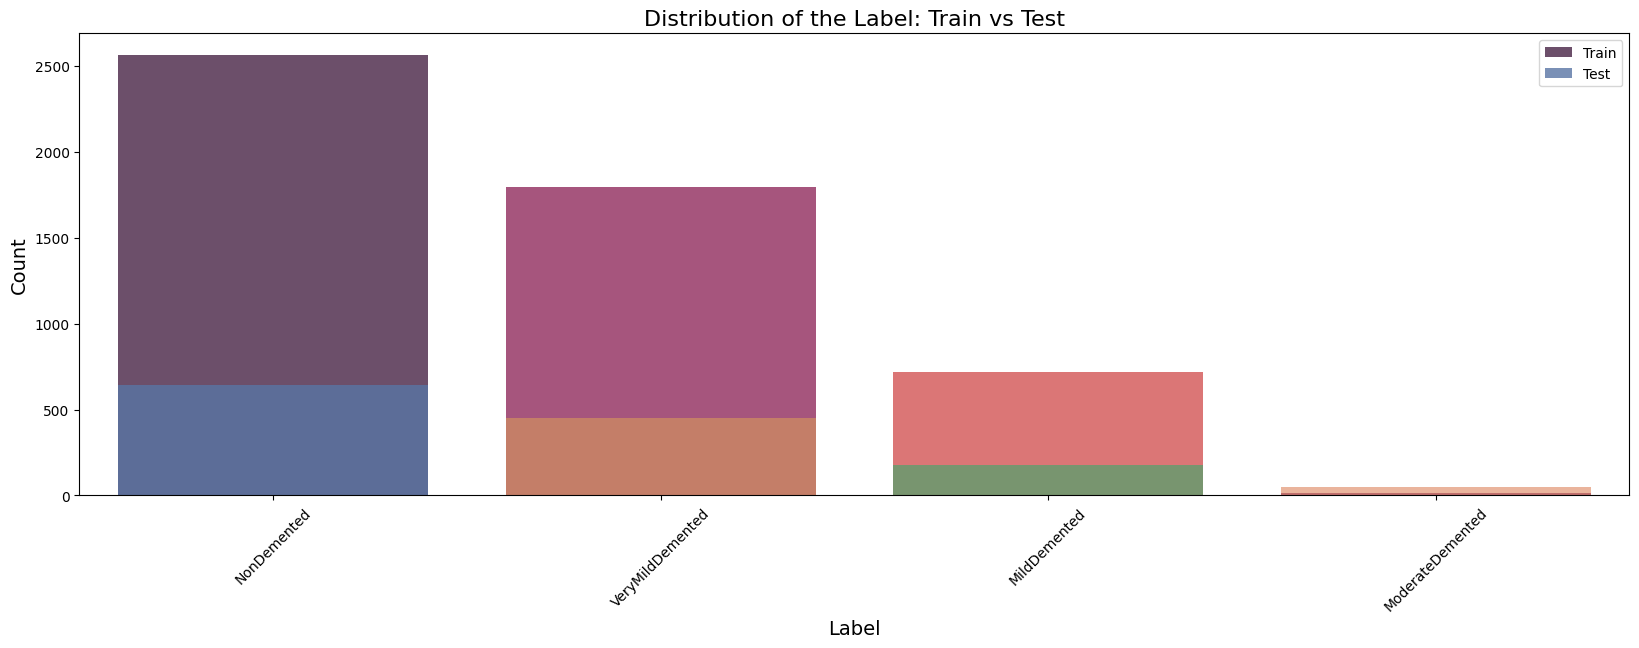

In [3]:
TRAIN_COUNT = TRAIN['label'].value_counts()
TEST_COUNT = TEST['label'].value_counts()

plt.figure(figsize=(20, 6))
sns.barplot(x=TRAIN_COUNT.index, y=TRAIN_COUNT.values, alpha=0.8, palette='rocket', label='Train')
sns.barplot(x=TEST_COUNT.index, y=TEST_COUNT.values, alpha=0.8, palette='deep', label='Test')
plt.title('Distribution of the Label: Train vs Test', fontsize=16)
plt.xlabel('Label', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45) 
plt.legend()
plt.show()

The dataset is very unbalanced, which could present some challenges to the models.

# Visualise example images of each class

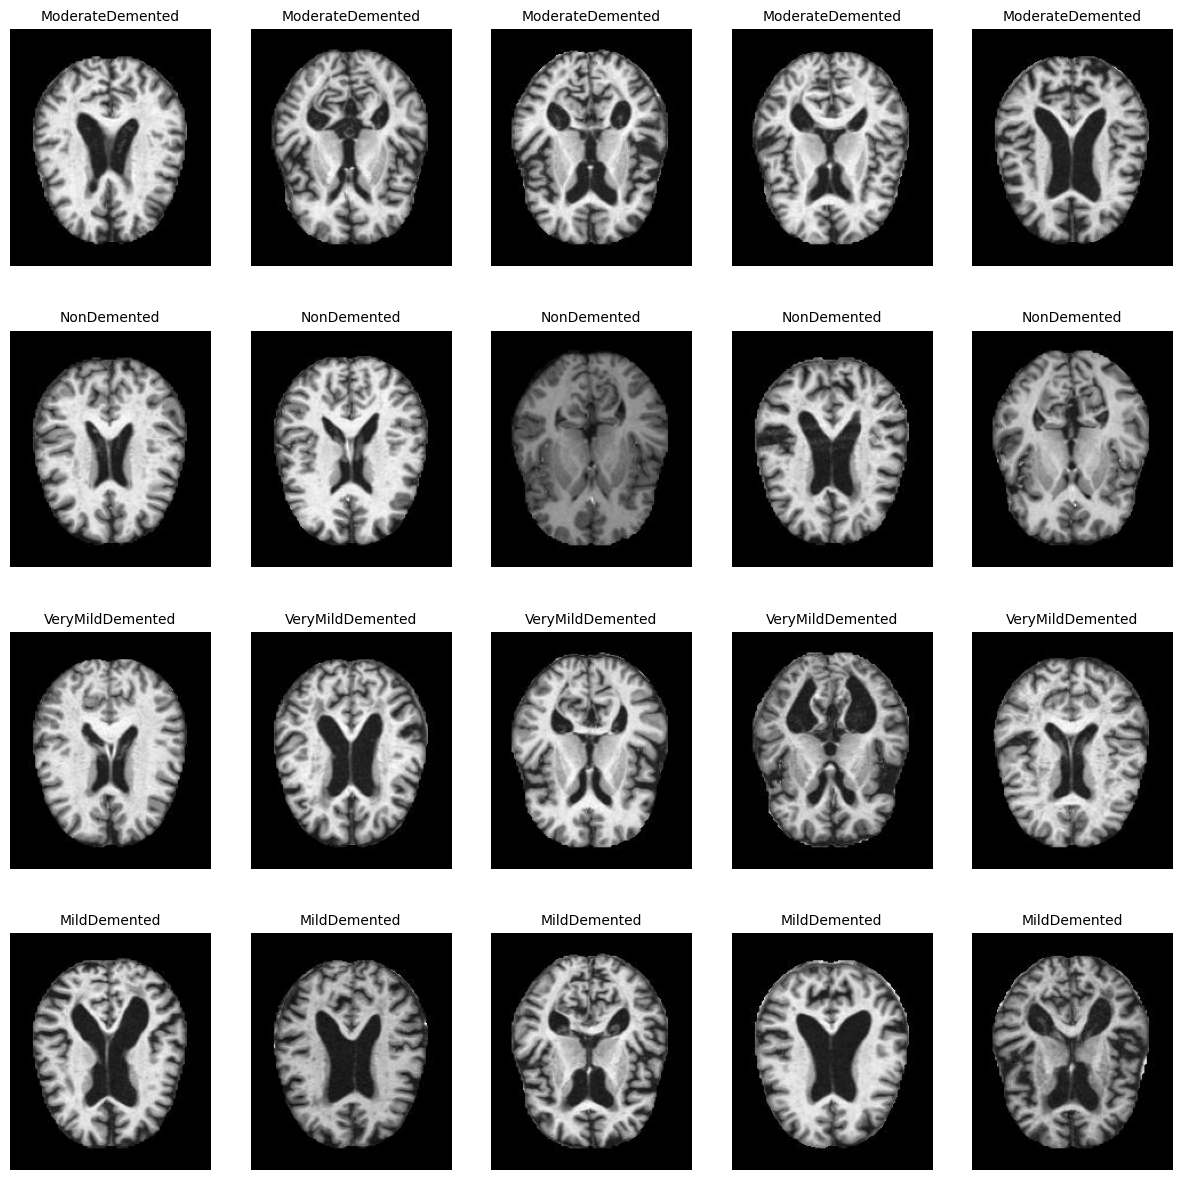

In [4]:
# Visualise the images of each class
LABELS = TRAIN['label'].unique()
NUM_LABELS = len(LABELS)
IMG_PER_LABEL = 5
plt.figure(figsize=(15,15))
for n, label in enumerate(LABELS):
    IMAGES = TRAIN[TRAIN['label'] == label].sample(IMG_PER_LABEL)
    for i, image in enumerate(IMAGES['image']):
        plt.subplot(NUM_LABELS, IMG_PER_LABEL, n * IMG_PER_LABEL + i + 1)
        plt.imshow(image, cmap='gray')
        plt.axis('off')
        plt.title(label, fontsize=10)

# Differences between the original image and its processed counterpart

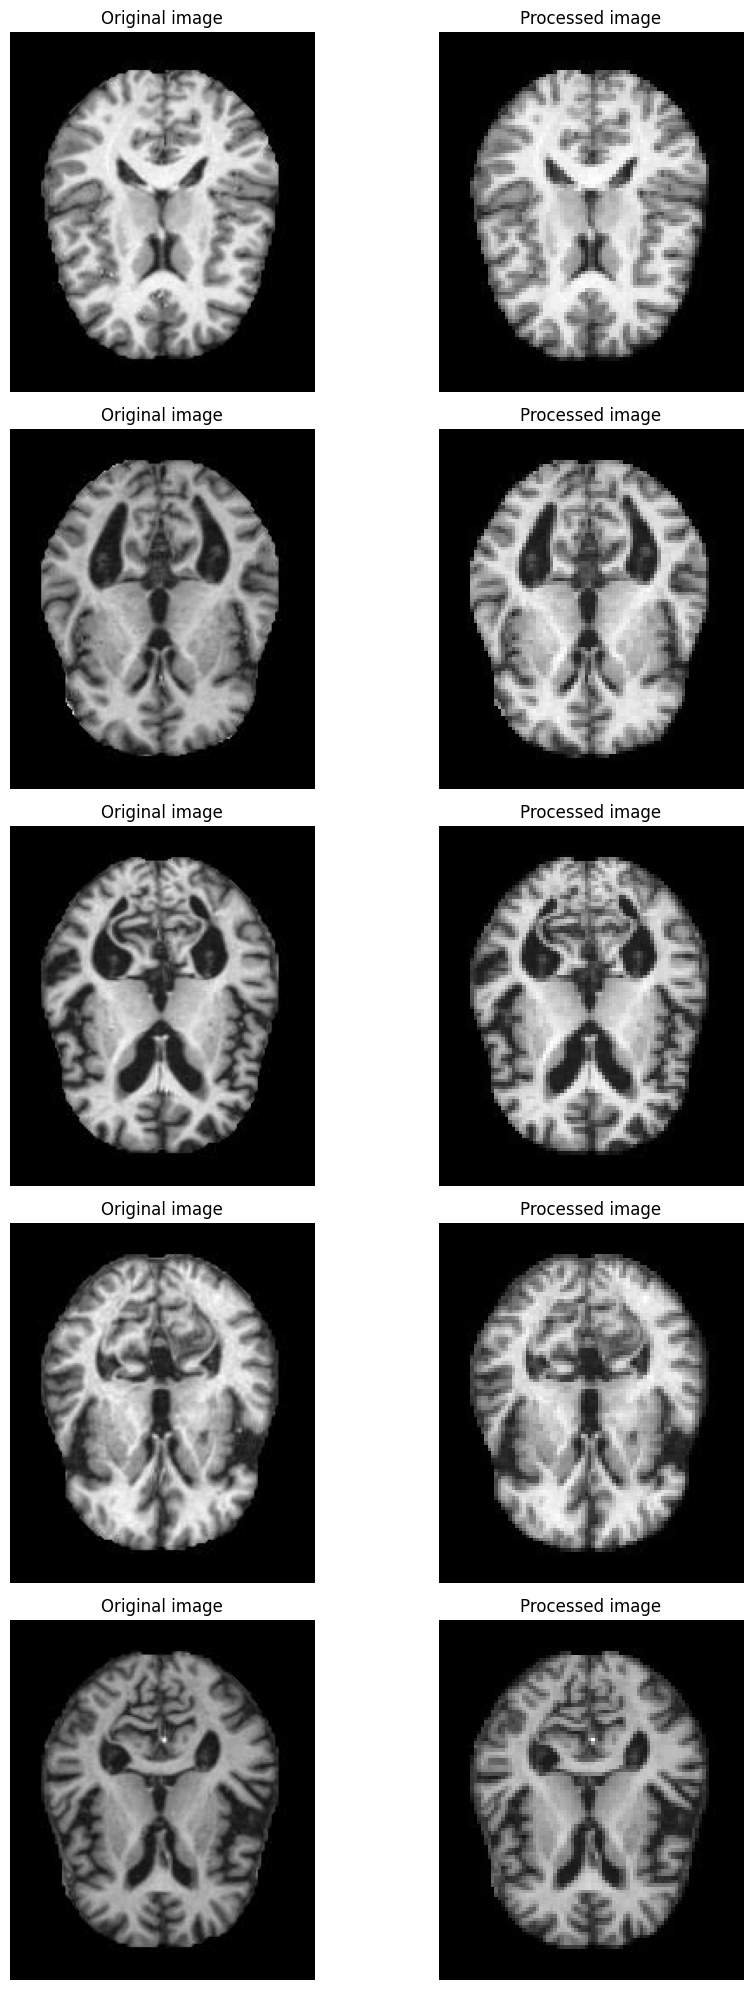

In [5]:
RAND = np.random.randint(0, len(TRAIN), 5)
fig, axs = plt.subplots(5, 2, figsize=(10, 20))

for i, idx in enumerate(RAND):
    axs[i, 0].imshow(TRAIN[IMAGECOLUMNNAME][idx], cmap='gray')
    axs[i, 0].set_title("Original image")
    axs[i, 0].axis('off')
    
    axs[i, 1].imshow(TRAIN[XCOL][idx], cmap='gray')
    axs[i, 1].set_title("Processed image")
    axs[i, 1].axis('off')

plt.tight_layout()
plt.show()


# Store the new images

In [6]:
# Save the preprocessed images
def storeInFolders(df, path, imageColumn, labelColumn):
    for index, row in df.iterrows():
        img = row[imageColumn]
        label = row[labelColumn]
        if not os.path.exists(path + label):
            os.makedirs(path + label)
        cv2.imwrite(path + label + '/' + str(index) + '.jpg', img)

storeInFolders(TRAIN, 'trainProcessed/', 'processedImage', 'label')
storeInFolders(TEST, 'testProcessed/', 'processedImage', 'label')

In [7]:
# Delete every previous variable to free up memory if needed
DELETE_OLD = False
if DELETE_OLD:
    del TRAIN, TEST, X_TRAIN, X_VAL, X_TEST, Y_TRAIN, Y_VAL, Y_TEST

# Import images to an Image Dataset

In [8]:
USE_PREPROCESSED = True

if USE_PREPROCESSED:
    TRAIN_PATH = 'trainProcessed'
    TEST_PATH = 'testProcessed'
    
else:
    TRAIN_PATH = PATH + 'train'
    TEST_PATH = PATH + 'test'

In [9]:
# Using Image Datasets to optimise training 
TRAIN_IMAGES = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_PATH,
    color_mode='rgb', # BW saves memory but does not often work with Trasnfer Learning 
    batch_size=BATCHSIZE,
    image_size=IMGSIZE,
    shuffle=True,
    seed=SEED,
    validation_split=TEST_SIZE,
    subset='training',
    verbose=True
)

VAL_IMAGES = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_PATH,
    color_mode='rgb', 
    batch_size=BATCHSIZE,
    image_size=IMGSIZE,
    shuffle=True,
    seed=SEED,
    validation_split=TEST_SIZE,
    subset='validation',
    verbose=True
)


TEST_IMAGES = tf.keras.preprocessing.image_dataset_from_directory(
    TEST_PATH,
    color_mode='rgb',
    batch_size=BATCHSIZE,
    image_size=IMGSIZE,
    shuffle=True,
    seed=SEED,
    verbose=True
)

# Ensure that the images have float values and that the labels are one hot encoded
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

def one_hot_label(image, label):
    label = tf.one_hot(label, 4)
    return image, label

TRAIN_IMAGES = TRAIN_IMAGES.map(one_hot_label, num_parallel_calls=AUTOTUNE).map(convert_to_float).prefetch(buffer_size=AUTOTUNE)
VAL_IMAGES = VAL_IMAGES.map(one_hot_label, num_parallel_calls=AUTOTUNE).map(convert_to_float).prefetch(buffer_size=AUTOTUNE)
TEST_IMAGES = TEST_IMAGES.map(one_hot_label, num_parallel_calls=AUTOTUNE).map(convert_to_float).prefetch(buffer_size=AUTOTUNE)



Found 5121 files belonging to 4 classes.
Using 4097 files for training.
Found 5121 files belonging to 4 classes.
Using 1024 files for validation.
Found 1279 files belonging to 4 classes.


In [10]:
# This function extracts all the images and respective labels from an Image dataset
# This is needed as, because they are stored as batches, doing .next() or similar
# would only retrieve BATCHSIZE images.
def extractFromTFwBatches(data):
    return np.concatenate([x for x, y in data], axis=0), np.concatenate([y for x, y in data], axis=0)
    

# Definition of the Model

In [11]:
# Creating some blocks to simplify the definition of the model
def preprocessingBlock(rotation=0.2, zoom=0.2, contrast=0.2):
    block = tf.keras.Sequential()
    block.add(tf.keras.layers.Rescaling(1./255))
    #block.add(tf.keras.layers.RandomFlip("horizontal"))
    block.add(tf.keras.layers.RandomContrast(contrast))
    block.add(tf.keras.layers.RandomZoom(zoom))
    block.add(tf.keras.layers.RandomRotation(rotation))
    return block

def denseBlock(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

def convBlock(filters):
    block =  tf.keras.Sequential([    
        tf.keras.layers.SeparableConv2D(filters=filters, kernel_size=5, activation="relu", padding='same'),
        tf.keras.layers.SeparableConv2D(filters=filters, kernel_size=5, activation="relu", padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(),
    ])
    
    return block

# Defining the model
inputs = tf.keras.layers.Input(shape=[IMGSIZE[0], IMGSIZE[1], 3])
#x = preprocess_input(inputs)
aug = preprocessingBlock(rotation=0.1, zoom=0.1, contrast=0.1)(inputs)
xception = tf.keras.applications.Xception(include_top=False, weights='imagenet')(aug)
globalavg = tf.keras.layers.GlobalAveragePooling2D()(xception)
denseblock1 = denseBlock(1024, 0.3)(globalavg)
denseblock2 = denseBlock(512, 0.2)(denseblock1)
denseblock3 = denseBlock(128, 0.2)(denseblock2)
outputs = tf.keras.layers.Dense(N_CLASSES, activation='softmax')(denseblock3)

# Build the model
MODEL = keras.Model(inputs, outputs)

CALLBACKS = [
    tf.keras.callbacks.EarlyStopping(patience=10, verbose=1, restore_best_weights=True, monitor = 'val_f1_score'),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=15, min_lr=0.00001, verbose=1),
    tf.keras.callbacks.ModelCheckpoint('modelBase.keras', verbose=1, save_best_only=True, save_weights_only=False, monitor='val_f1_score', mode='max', save_freq='epoch'),#
]

METRICS = [tf.keras.metrics.AUC(name='auc'),
           tf.keras.metrics.F1Score(average = 'weighted')]

MODEL.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=METRICS)


HIST = MODEL.fit(TRAIN_IMAGES,
                    epochs=N_EPOCHS,
                    validation_data=VAL_IMAGES,
                callbacks = CALLBACKS)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/70
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - auc: 0.5854 - f1_score: 0.3820 - loss: 1.7189
Epoch 1: val_f1_score improved from -inf to 0.34205, saving model to modelBase.keras
65/65 ━━━━━━━━━━━━━━━━━━━━ 52s 263ms/step - auc: 0.5863 - f1_score: 0.3827 - loss: 1.7155 - val_auc: 0.7426 - val_f1_score: 0.3420 - val_loss: 1.4386 - learning_rate: 0.0010
Epoch 2/70
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - auc: 0.7897 - f1_score: 0.5157 - loss: 1.1066
Epoch 2: val_f1_score improved from 0.34205 to 0.56863, saving model to modelBase.keras
65/65 ━━━━━━━━━━━━━━━━━━━━ 15s 226ms/step - auc: 0.7898 - f1_score: 0.5158 - loss: 1.1062 - val_auc: 0.8546 - val_f1_score: 0.5686 - val_loss: 0.9391 - learning_rate: 0.0010
Epoch 3/70
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - auc: 0.8303 - f1_score: 0.5514 - loss: 0.9774
Epoch 3: val_f1_score did not improve from 0.56863
65/65 ━━━━━━━━━━━━━━━━━━━━ 19s 202ms/step - auc: 0.8304 - f1_score: 0.5515 - 

In [12]:
# Extracting the images and respective labels
IMGS_T, LABS_T =extractFromTFwBatches(TRAIN_IMAGES)
IMGS_V, LABS_V =extractFromTFwBatches(VAL_IMAGES)
IMGS_TS, LABS_TS =extractFromTFwBatches(TEST_IMAGES)

# Model Evaluation

In [13]:

# Evaluating the model based on the set metrics
MODEL.evaluate(TRAIN_IMAGES)
MODEL.evaluate(VAL_IMAGES)
MODEL.evaluate(TEST_IMAGES)

# Predicts the label of each individual image, storing them in a list
# Uses this list to evaluate the model
# Since the dataset is shuffled, conventional methods do not work
# as they might use the wrong labels instead
def evaluateShuffledSet(tensor_df, model):
    PREDICTIONS = []
    TRUE_LABELS = []
    for x, y in tensor_df:
        preds = model.predict(x, verbose = False)
        preds = np.argmax(preds, axis=1)
        y_true = np.argmax(y, axis=1)
        
        PREDICTIONS.extend(preds)
        TRUE_LABELS.extend(y_true)
        
    print(classification_report(TRUE_LABELS, PREDICTIONS))

    return PREDICTIONS, TRUE_LABELS

# While not the same as the .evaluate() method, it is still
# closer than the conventional method of prediction on TRAIN_IMAGES
P_TRAIN, L_TRAIN = evaluateShuffledSet(TRAIN_IMAGES, MODEL)
P_VAL, L_VAL = evaluateShuffledSet(VAL_IMAGES, MODEL)
P_TEST, L_TEST = evaluateShuffledSet(TEST_IMAGES, MODEL)




65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - auc: 0.9984 - f1_score: 0.9638 - loss: 0.0919
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - auc: 0.9930 - f1_score: 0.9328 - loss: 0.1884
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - auc: 0.8912 - f1_score: 0.6460 - loss: 1.0791
              precision    recall  f1-score   support

           0       0.97      0.91      0.94       570
           1       1.00      0.84      0.91        44
           2       1.00      0.95      0.98      2040
           3       0.91      0.99      0.95      1443

    accuracy                           0.96      4097
   macro avg       0.97      0.93      0.95      4097
weighted avg       0.96      0.96      0.96      4097

              precision    recall  f1-score   support

           0       0.94      0.86      0.90       147
           1       1.00      0.38      0.55         8
           2       0.99      0.92      0.95       520
           3       0.85      0.98      0.91       349

    accuracy                 

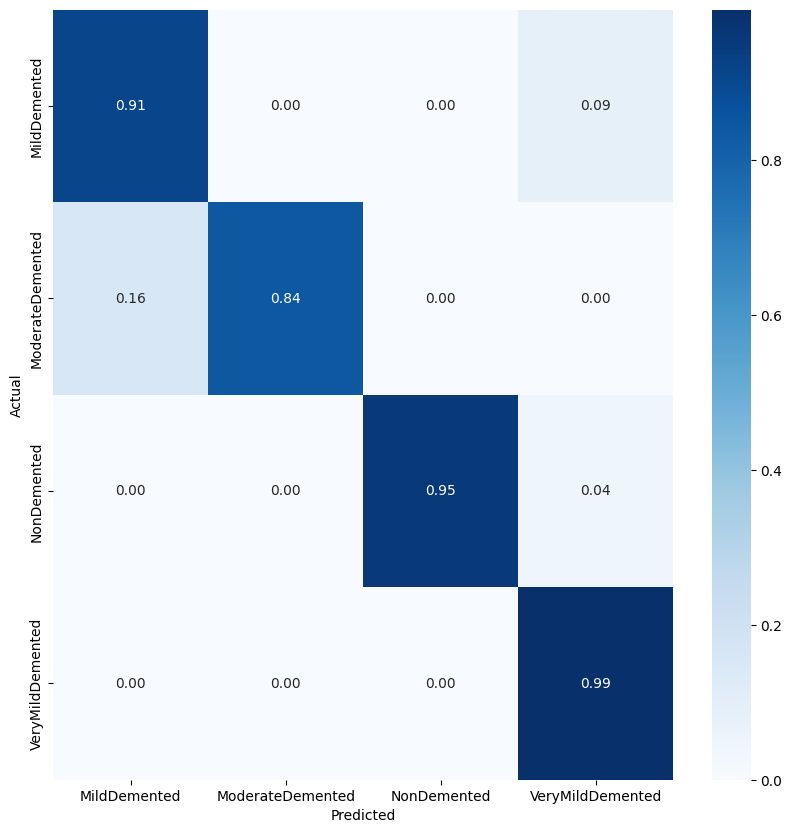

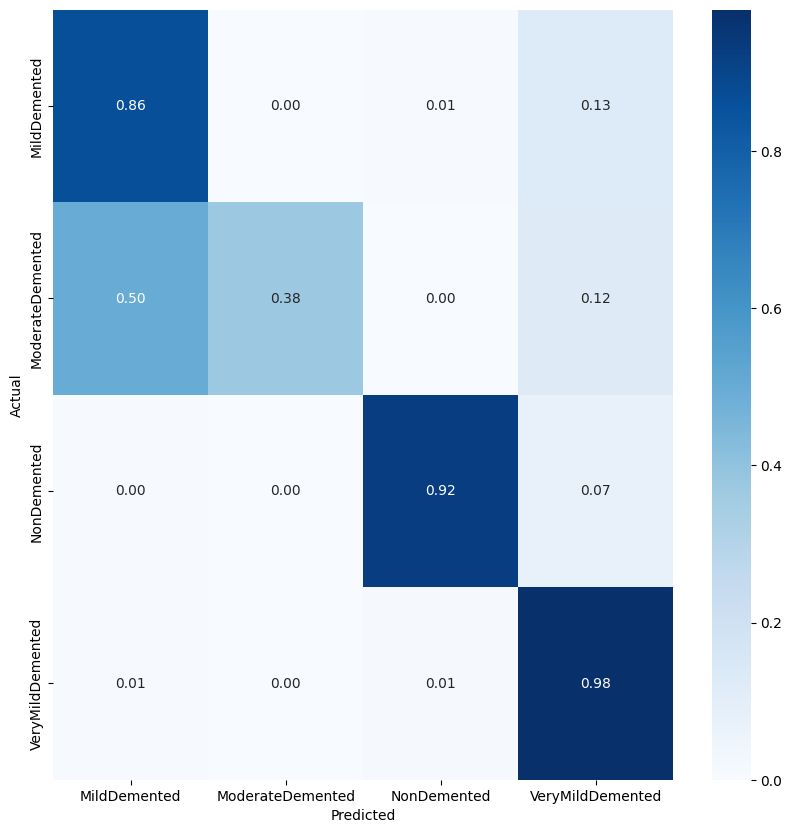

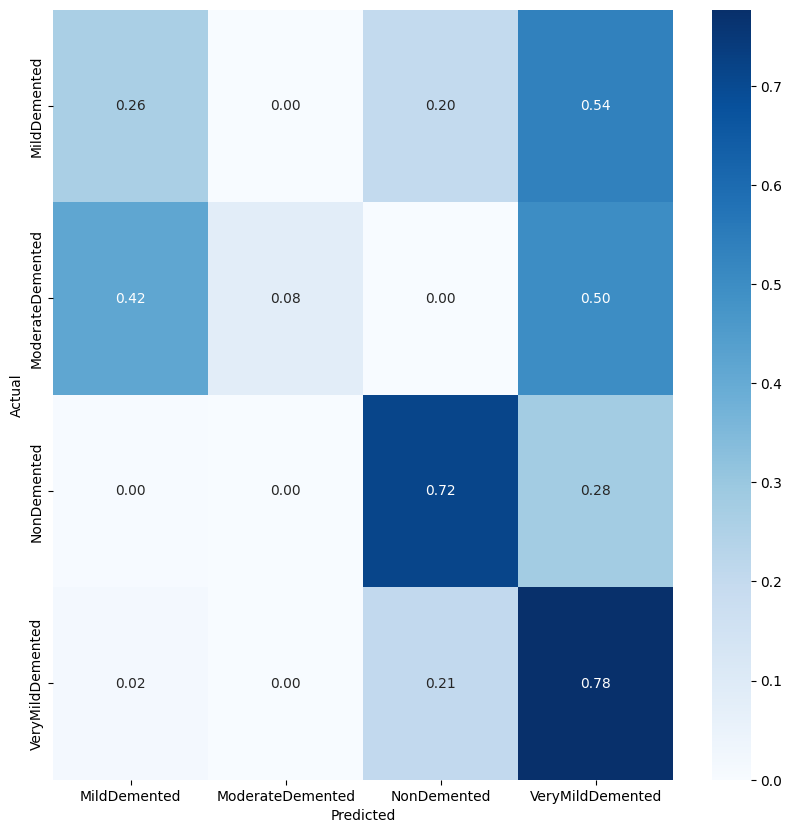

In [14]:
# Plot the confusion matrix of the model to analyse the error
def plot_confusion(y_true, y_pred, classes):
    fig, ax = plt.subplots(figsize=(10, 10))
    cm = confusion_matrix(y_true, y_pred)
    cm = cm / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm, annot=True, fmt=".2f", cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

plot_confusion(L_TRAIN, P_TRAIN, ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented'])
plot_confusion(L_VAL, P_VAL, ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented'])
plot_confusion(L_TEST, P_TEST, ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented'])


From a brief analysis:
- The model seems to tempted to predict 'VeryMildDemented' quite often on the test set.
- The model tends to classify "ModerateDemented" cases as 'MildDemented', and also deems half of them to be 'VeryMildDemented' on the test set.
- It seems to predict well both 'NonDemented' and 'VeryMildDemented' on all sets.
- The large scale missclassification of "ModerateDemented" images on the test set may suggest those images differ significantly from the ones used for training and validation.
- Something similar could be happening with the 'MildDemented' cases, as they were also not classified as well as the validation set.

In [15]:
# Saving the final baseline model
MODEL.save("bestModelBaseline.keras")